In [1]:
!pip -q install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from scipy.stats import linregress

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

After running the cell above and following the instructions to mount your Google Drive, you can find the path to your file. A common location for user files is `'/content/drive/My Drive/your_folder/your_file.xlsx'`.

In [3]:
# Load data
# define path
# PATH = "/content/drive/My Drive/MIE1623-2026/cleaned_A2.xlsx"
PATH = "cleaned_A2.xlsx"
df_raw = pd.read_excel(PATH)
df_raw.head()

,Patient,Delivery Date,Day of Week,Delivery Time,CS type,OR Arrival Time,OR Departure Time,Total Patient OR time,Delivery_DateTime
0,1,2013-04-01,Monday,01:21:00,Unplanned,2013-04-01 00:46:35.000,2013-04-01 03:51:24.000,184,2013-04-01 01:21:00
1,3,2013-04-01,Monday,11:23:00,Planned-not as sched,2013-04-01 10:36:50.623,2013-04-01 12:01:40.623,84,2013-04-01 11:23:00
2,4,2013-04-01,Monday,12:33:00,Unplanned,2013-04-01 11:47:01.307,2013-04-01 13:05:30.307,78,2013-04-01 12:33:00
3,5,2013-04-01,Monday,16:37:00,Unplanned,2013-04-01 16:20:29.167,2013-04-01 17:30:20.167,69,2013-04-01 16:37:00
4,6,2013-04-02,Tuesday,08:28:00,Planned-as scheduled,2013-04-02 07:53:40.260,2013-04-02 09:19:08.260,85,2013-04-02 08:28:00


##1.1 % of performed scheduled C-section on time (target 98%)

In [4]:
df1 = df_raw.copy()
planned_as_sched_count = df1[df1['CS type'] == 'Planned-as scheduled'].shape[0]
print(f"The number of 'Planned-as scheduled' in 'CS type' is: {planned_as_sched_count}")

total_planned_count = df1[(df1['CS type'] == 'Planned-as scheduled') | (df1['CS type'] == 'Planned-not as sched')].shape[0]
print(f"The number of 'Planned-as scheduled' and 'lanned-not as sched' in 'CS type' is: {total_planned_count}")

The number of 'Planned-as scheduled' in 'CS type' is: 892
The number of 'Planned-as scheduled' and 'lanned-not as sched' in 'CS type' is: 1103


In [5]:
Performed_ontime = (planned_as_sched_count / total_planned_count) * 100

print(f"Proportion of performed scheduled C-sections on time is: {Performed_ontime:.1f}%")

Proportion of performed scheduled C-sections on time is: 80.9%


By month

In [6]:
df1['Delivery Date'] = pd.to_datetime(df1['Delivery Date'], errors='coerce')


In [7]:
df1['YearMonth'] = df1['Delivery Date'].dt.strftime('%Y-%m')
print(df1[['Delivery Date', 'YearMonth']].head())

  Delivery Date YearMonth
0    2013-04-01   2013-04
1    2013-04-01   2013-04
2    2013-04-01   2013-04
3    2013-04-01   2013-04
4    2013-04-02   2013-04


In [8]:
df_monthly_proportions = df1.groupby('YearMonth').agg(
    planned_as_scheduled_count=('CS type', lambda x: (x == 'Planned-as scheduled').sum()),
    total_planned_count=('CS type', lambda x: ((x == 'Planned-as scheduled') | (x == 'Planned-not as sched')).sum())
).reset_index()

df_monthly_proportions['performed_on_time_percentage'] = (
    (df_monthly_proportions['planned_as_scheduled_count'] / df_monthly_proportions['total_planned_count']) * 100
)
df_monthly_proportions.head(12)

,YearMonth,planned_as_scheduled_count,total_planned_count,performed_on_time_percentage
0,2013-04,78,87,89.655172
1,2013-05,82,104,78.846154
2,2013-06,74,99,74.747475
3,2013-07,81,96,84.375000
4,2013-08,80,104,76.923077
5,2013-09,75,93,80.645161
6,2013-10,71,90,78.888889
7,2013-11,70,90,77.777778
8,2013-12,67,85,78.823529
9,2014-01,80,94,85.106383


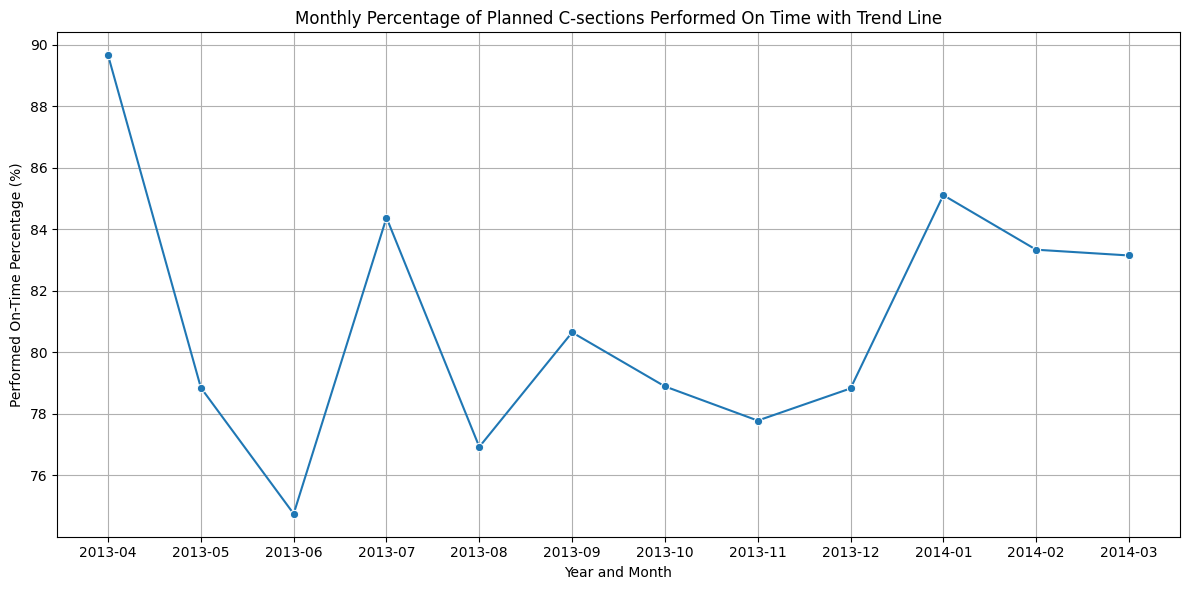


Linear Trend Analysis:
Slope: 0.0016
Intercept: -1120.1405
R-squared: 0.0018
P-value: 0.8947
There is no statistically significant linear trend in the performed on-time percentage (p >= 0.05).


In [9]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='YearMonth', y='performed_on_time_percentage', data=df_monthly_proportions, marker='o')
#sns.regplot(x='YearMonth', y='performed_on_time_percentage', data=df_monthly_proportions, scatter=False, color='red', line_kws={'linestyle':'--'})
plt.title('Monthly Percentage of Planned C-sections Performed On Time with Trend Line')
plt.xlabel('Year and Month')
plt.ylabel('Performed On-Time Percentage (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Analyze the trend (linear regression coefficients)
# For trend analysis, calculate the slope of the regression line.

# create a datetime version ONLY for regression
df_monthly_proportions['YearMonth_dt'] = pd.to_datetime(
    df_monthly_proportions['YearMonth'],
    format='%Y-%m'
)

x_numeric = df_monthly_proportions['YearMonth_dt'].apply(lambda d: d.toordinal())
y_values = df_monthly_proportions['performed_on_time_percentage']


# x_numeric = df_monthly_proportions['YearMonth'].apply(lambda date: date.toordinal())
# y_values = df_monthly_proportions['performed_on_time_percentage']

slope, intercept, r_value, p_value, std_err = linregress(x_numeric, y_values)

print(f"\nLinear Trend Analysis:")
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    trend_direction = "increasing" if slope > 0 else "decreasing"
    print(f"There is a statistically significant {trend_direction} trend in the performed on-time percentage (p < 0.05).")
else:
    print(f"There is no statistically significant linear trend in the performed on-time percentage (p >= 0.05).")

##1.2 % of unplanned/ emerency

In [10]:
df2 = df_raw.copy()
unplanned_count = df2[df2['CS type'] == 'Unplanned'].shape[0]
print(f"The number of 'Unplanned' in 'CS type' is: {unplanned_count}")

All_count = df2[(df2['CS type'] == 'Planned-as scheduled') | (df2['CS type'] == 'Planned-not as sched')|(df2['CS type'] == 'Unplanned')].shape[0]
print(f"The number of All in 'CS type' is: {All_count}")

The number of 'Unplanned' in 'CS type' is: 1040
The number of All in 'CS type' is: 2143


In [11]:
Unplanned = (unplanned_count / All_count) * 100

print(f"Proportion of Unplanned is: {Unplanned:.1f}%")

Proportion of Unplanned is: 48.5%


##2.1 OR Utilization rate during office hour

In [12]:
# -------- parameters --------
OR_COUNT = 3
WORK_START_H = 9
WORK_END_H   = 17  # 9-17 means 9:00 to 17:00

In [13]:
df3 = df_raw.copy()

# parse datetime
df3["Delivery Date"] = pd.to_datetime(df3["Delivery Date"])
df3["OR Arrival Time"] = pd.to_datetime(df3["OR Arrival Time"])
df3["OR Departure Time"] = pd.to_datetime(df3["OR Departure Time"])

# keep Mon-Fri weekdays
df3 = df3[df3["Delivery Date"].dt.weekday <= 4]  # Mon-Fri

# compute overlap minutes within working window
work_start = df3["Delivery Date"] + pd.to_timedelta(WORK_START_H, unit="h")
work_end   = df3["Delivery Date"] + pd.to_timedelta(WORK_END_H, unit="h")

clip_start = df3["OR Arrival Time"].where(df3["OR Arrival Time"] > work_start, work_start)
clip_end   = df3["OR Departure Time"].where(df3["OR Departure Time"] < work_end, work_end)

df3["overlap_min"] = (clip_end - clip_start).dt.total_seconds() / 60
df3["overlap_min"] = df3["overlap_min"].clip(lower=0)

# -------- annual utilization --------
work_minutes_per_day = (WORK_END_H - WORK_START_H) * 60
num_weekdays = len(pd.date_range(df3["Delivery Date"].min(), df3["Delivery Date"].max(), freq="B"))

total_used = df3["overlap_min"].sum()
total_capacity = num_weekdays * OR_COUNT * work_minutes_per_day
annual_util = total_used / total_capacity

print(f"Annual utilization (Mon-Fri {WORK_START_H}:00-{WORK_END_H}:00): {annual_util:.2%}")

# -------- daily utilization distribution --------
daily = df3.groupby("Delivery Date")["overlap_min"].sum().reset_index()
daily["daily_util"] = daily["overlap_min"] / (OR_COUNT * work_minutes_per_day)

print("Daily utilization:")
print(daily["daily_util"].describe(percentiles=[0.9])[["mean","50%","90%","max"]])



Annual utilization (Mon-Fri 9:00-17:00): 26.12%
Daily utilization:
mean    0.261222
50%     0.269150
90%     0.426269
max     0.540830
Name: daily_util, dtype: float64


In [14]:
df4 = df_raw.copy()

# parse datetime
df4["Delivery Date"] = pd.to_datetime(df4["Delivery Date"])
df4["OR Arrival Time"] = pd.to_datetime(df4["OR Arrival Time"])
df4["OR Departure Time"] = pd.to_datetime(df4["OR Departure Time"])

# keep Mon-Fri weekdays
df4 = df4[df4["Delivery Date"].dt.weekday <= 4]  # Mon–Fri

# full grid (includes zero hours)
days = pd.date_range(df4["Delivery Date"].min(), df4["Delivery Date"].max(), freq="B")
hours = range(WORK_START_H, WORK_END_H)
grid = pd.MultiIndex.from_product([days, hours], names=["date", "hour"]).to_frame(index=False)

#count overlaps per hour (non-zero only)
records = []
for day, arr, dep in df4[["Delivery Date", "OR Arrival Time", "OR Departure Time"]].itertuples(index=False):
    for h in hours:
        h_start = day + pd.Timedelta(hours=h)
        h_end   = day + pd.Timedelta(hours=h+1)
        if min(dep, h_end) > max(arr, h_start):    # overlap exists
            records.append((day, h))

nonzero = pd.DataFrame(records, columns=["date", "hour"])
counts = nonzero.groupby(["date", "hour"]).size().reset_index(name="concurrent_cases")

# merge onto full grid -> fill zeros
concurrency = grid.merge(counts, on=["date", "hour"], how="left")
concurrency["concurrent_cases"] = concurrency["concurrent_cases"].fillna(0).astype(int)

# #summary
s = concurrency["concurrent_cases"]
count = len(s)

# Calculate key metrics first
share_0 = (s == 0).mean()
share_1 = ((s >= 1) & (s < 2)).mean()
share_2 = ((s >= 2) & (s < 3)).mean()
share_3 = ((s >= 3) & (s < 4)).mean()
share_overflow = (s > 3).mean()      # Need > 3 rooms
share_saturation = (s >= 3).mean()   # Need >= 3 rooms

print("=" * 60)
print(f"   OPERATING ROOM CAPACITY ANALYSIS (N={count} hours)")
print("=" * 60)

print("\n--- [1] General Statistics ---")
print(f"Average Concurrent Surgeries:  {s.mean():.2f}")
print(f"Median Concurrent Surgeries:   {s.median():.2f}")
print(f"Max Peak Demand:               {s.max():.0f} rooms")

print("\n--- [2] Hourly Utilization Breakdown ---")
print(f"0 Rooms Busy (IDLE):           {share_0:.2%}   (Hospital is empty)")
print(f"1 Room  Busy:                  {share_1:.2%}")
print(f"2 Rooms Busy:                  {share_2:.2%}")
print(f"3 Rooms Busy (FULL):           {share_3:.2%}   (System at capacity)")

print("\n--- [3] Critical Risk Metrics (Decision Drivers) ---")
print(f"SATURATION Probability (>=3):  {share_saturation:.2%}   (Probability of being full or over)")
print(f"OVERFLOW Probability (>3):     {share_overflow:.2%}   <-- KEY METRIC (Demand exceeds Supply)")

print("\n--- [4] Conclusion for Question 6 ---")
# The hospital wants 98% on-time, meaning they tolerate < 2% failure/overflow.
tolerance = 0.02

if share_overflow < tolerance:
    print(f"TARGET MET: Overflow risk ({share_overflow:.2%}) is BELOW the 2% tolerance.")
    print("   Recommendation: Do NOT build the 4th OR. Current capacity is sufficient.")
else:
    print(f"TARGET MISSED: Overflow risk ({share_overflow:.2%}) EXCEEDS the 2% tolerance.")
    print("   Recommendation: Consider building the 4th OR.")

print("=" * 60)

# optional slack rooms
concurrency["slack_rooms"] = (OR_COUNT - concurrency["concurrent_cases"]).clip(lower=0)

   OPERATING ROOM CAPACITY ANALYSIS (N=2088 hours)

--- [1] General Statistics ---
Average Concurrent Surgeries:  1.28
Median Concurrent Surgeries:   1.00
Max Peak Demand:               4 rooms

--- [2] Hourly Utilization Breakdown ---
0 Rooms Busy (IDLE):           18.92%   (Hospital is empty)
1 Room  Busy:                  42.86%
2 Rooms Busy:                  30.75%
3 Rooms Busy (FULL):           6.56%   (System at capacity)

--- [3] Critical Risk Metrics (Decision Drivers) ---
SATURATION Probability (>=3):  7.47%   (Probability of being full or over)
OVERFLOW Probability (>3):     0.91%   <-- KEY METRIC (Demand exceeds Supply)

--- [4] Conclusion for Question 6 ---
TARGET MET: Overflow risk (0.91%) is BELOW the 2% tolerance.
   Recommendation: Do NOT build the 4th OR. Current capacity is sufficient.
